# Introduction

## Background

Lagrangian: The Lagrangian, denoted by $$L$$, is a function used in the framework of classical mechanics to describe the difference between kinetic and potential energy in a system. It plays a central role in the formulation of the Euler-Lagrange equations, which govern the behavior of a physical system.

The Lagrangian is defined as:

$$L(q, \dot{q}, t) = T(q, \dot{q}, t) - U(q, t)$$

Where:

- $$q$$ represents the generalized coordinates of the system. These are variables that describe the configuration of the system in terms of its degrees of freedom. For example, in a simple pendulum, the generalized coordinate could be the angle at which the pendulum is displaced from the vertical.

- $$\dot{q}$$ denotes the time derivative of the generalized coordinates, which are the generalized velocities. These represent how quickly the generalized coordinates are changing with time.

- $$t$$ represents time.

- $$T(q, \dot{q}, t)$$ is the kinetic energy of the system. It depends on the generalized coordinates, their time derivatives, and time. For example, in a system of particles, it might be expressed as a sum of the kinetic energies of each particle.

- $$U(q, t)$$ is the potential energy of the system. It depends on the generalized coordinates and time. It describes the energy associated with the configuration of the system.

The Lagrangian, by encapsulating the difference between kinetic and potential energy, provides a concise and powerful way to describe the dynamics of a system. By using the Lagrangian, one can formulate the principle of stationary action, which states that the actual motion of a system is the one that makes the action integral stationary (either a minimum or maximum). This leads to the Euler-Lagrange equations, which, when solved, yield the equations of motion for the system.

The advantage of using the Lagrangian formulation is that it often provides a more intuitive and elegant approach to solving complex physical problems compared to other methods like Newton's laws of motion. It is particularly useful in situations with constraints, symmetries, and when dealing with systems involving many degrees of freedom.



Euler Lagrange Equations: The Euler-Lagrange equations are a set of differential equations that describe the behavior of a system in classical mechanics. They are named after Leonhard Euler and Joseph-Louis Lagrange, who made significant contributions to the field.

In the context of physics, these equations are used to find the path that a physical system will naturally follow in order to minimize or maximize a certain quantity called the action. The action is defined as the integral of a quantity called the Lagrangian over time, typically denoted by \(S\), and it is given by:

$$S = \int_{t_1}^{t_2} L(q, \dot{q}, t) \, dt$$

Where:
- \(S\) is the action.
- \(L\) is the Lagrangian, which is a function that describes the difference between kinetic and potential energy in a system. It depends on the generalized coordinates \(q\), their time derivatives \(\dot{q}\), and time \(t\).
- \(t_1\) and \(t_2\) are the initial and final times, respectively.

The generalized coordinates \(q\) represent the configuration of the system, and \(\dot{q}\) represents the time rate of change of these coordinates (i.e., the generalized velocities).

The Euler-Lagrange equations are derived by finding the path \(q(t)\) that minimizes the action \(S\). Mathematically, they are expressed as:

$$\frac{d}{dt} \left(\frac{\partial L}{\partial \dot{q}}\right) - \frac{\partial L}{\partial q} = 0$$

This is a set of second-order partial differential equations, one for each generalized coordinate \(q\). Solving these equations yields the equations of motion for the system.

The Euler-Lagrange equations are fundamental in classical mechanics and have applications in various fields of physics and engineering. They are a cornerstone in the formulation of the principle of least action, which underlies much of classical physics.



Legendre Transformation: The Legendre transformation is a mathematical operation that is widely used in physics, especially in the context of thermodynamics and classical mechanics. It allows one to change the independent variables of a function, which can be very useful in simplifying the formulation of physical problems.

Given a function $$f(x)$$, the Legendre transformation creates a new function $$g(p)$$, where $$p$$ is related to $$x$$ through the derivative of $$f$$ with respect to $$x$$. Mathematically, the Legendre transformation is defined as follows:

$$g(p) = px - f(x)$$

Where:

- $$x$$ and $$p$$ are related by $$p = \frac{{df}}{{dx}}$$, which means $$p$$ is the derivative of $$f$$ with respect to $$x$$.
  
- $$f(x)$$ is called the "original" or "conjugate" function.

- $$g(p)$$ is the transformed or Legendre-transformed function.

This transformation is often used to switch between different representations of a physical system, making certain properties or constraints more apparent. It is particularly useful in thermodynamics, where it allows us to change the representation of energy from one set of variables (e.g., temperature and volume) to another set (e.g., temperature and entropy), which might be more appropriate for certain types of problems.

In classical mechanics, the Legendre transformation plays a key role in transforming between different representations of the Lagrangian and Hamiltonian formulations. The Lagrangian is a function of generalized coordinates and their time derivatives, while the Hamiltonian is a function of generalized coordinates and their conjugate momenta. The Legendre transformation connects these two formulations.

In summary, the Legendre transformation is a powerful mathematical tool used to switch between different representations of physical systems, which can often lead to a more natural and insightful description of the underlying physics.


The Hessian Matrix: 

## To Do

1. Construct a motion primitive library that summarizes the characteristics of arcs
that exist within segments of the solution space.
2. Construct a motion primitive graph that discretely approximates a subset of the
continuous solution space.
3. Search the graph for motion primitive sequences that serve as candidates for initial
guesses for trajectories.
4. Construct an initial guess for each trajectory by refining each motion primitive
sequence.
5. Correct each initial guess to produce a continuous trajectory with impulsive
maneuvers using direct collocation and local optimization.
6. Compute additional transfers spanning segments of the design space.
7. Look into graph search/machine learning methods for stitching together arcs


# Initialization

## Imports

In [1]:
import sys
import os
import random
import math

import numpy as np 
from numpy import cos, sin
import matplotlib
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.graph_objects as go

import pickle as pkl
import PIL.Image as Image



from PIL import Image
import copy
import seaborn as sns
from scipy.integrate import odeint
from scipy.integrate import solve_ivp


import gym
from gym import Env, spaces
import time
import operator



from datetime import datetime
import navpy as nav


from poliastro.bodies import Sun, Earth, Moon
from poliastro.ephem import Ephem
from poliastro.frames import Planes
from poliastro.plotting import StaticOrbitPlotter
from poliastro.plotting.misc import plot_solar_system
from poliastro.twobody import Orbit
from poliastro.util import norm, time_range
from poliastro.constants import J2000
from poliastro.plotting import OrbitPlotter3D
from poliastro.plotting import OrbitPlotter2D
from poliastro.twobody.sampling import EpochsArray, TrueAnomalyBounds, EpochBounds
from poliastro.maneuver import Maneuver
from poliastro.twobody.propagation import propagate, cowell
from poliastro import constants



from astropy import units as u
from astropy.time import Time, TimeDelta
from astropy.utils.data import conf
from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body

from astroquery.jplhorizons import Horizons

conf.dataurl
conf.remote_timeout = 10000
solar_system_ephemeris.set("jpl")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
from torch.distributions import Normal
from torch.autograd import gradcheck
import torch.nn.init as init
from torch.nn.utils import clip_grad_norm_, clip_grad_value_

from captum.attr import LayerIntegratedGradients
from captum.attr import Saliency
from torchviz import make_dot


from IPython.display import clear_output
import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from math import sqrt
from scipy.optimize import fsolve

## Functions

In [112]:
def f(x, coeffs):
    """
    Compute the value of the quintic polynomial at x.
    coeffs: List of coefficients [a, b, c, d, e, f]
    """
    a, b, c, d, e, f = coeffs
    return a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x + f

def f_prime(x, coeffs):
    """
    Compute the derivative of the quintic polynomial at x.
    coeffs: List of coefficients [a, b, c, d, e, f]
    """
    a, b, c, d, e, f = coeffs
    return 5*a*x**4 + 4*b*x**3 + 3*c*x**2 + 2*d*x + e

def newtons_method(coefficients, initial_guess, tolerance=1e-10, max_iterations=1000):
    x = initial_guess
    for _ in range(max_iterations):
        f_value = f(x, coefficients)
        f_prime_value = f_prime(x, coefficients)
        x = x - f_value / f_prime_value
        if abs(f_value) < tolerance:
            return x
    raise Exception("Newton's method did not converge")
def lunar_Orbit_DEQ(t, x):
    
    mu_earth = 398600.4
    mu_moon = 4902.8
    
    #Extract the position components from the state vector
    X_m = x[0]
    Y_m = x[1]
    Z_m = x[2]
    
    X_s = x[3]
    Y_s = x[4]
    Z_s = x[5]
    
    r_m = np.array([X_m, Y_m, Z_m])
    rm = np.linalg.norm(r_m)

    r_s = np.array([X_s, Y_s, Z_s])
    rs = np.linalg.norm(r_s)
    
    r_m_s = r_m - r_s
    rms = np.linalg.norm(r_m_s)
    #Extract the velocities from the state vector
    vX_m = x[6]
    vY_m = x[7]
    vZ_m = x[8]
    
    vX_s = x[9]
    vY_s = x[10]
    vZ_s = x[11]
    
    a_earth_m = -mu_earth*r_m/rm**3
    a_earth_s = -mu_earth*r_s/rs**3

    a_moon_s = mu_moon*((r_m_s/rms**3) - (r_m/rm**3))
    
    a_m = a_earth_m
    a_s = a_earth_s + a_moon_s
    
    dxdt = [vX_m, vY_m, vZ_m, vX_s, vY_s, vZ_s, a_m[0], a_m[1], a_m[2], a_s[0], a_s[1], a_s[2]]
    
    return dxdt

def ECI_2_MFR_DCM(r_m, v_m, r_s):
    r_m_q = []
    r_s_q = []
    Q_ = []
    
    for n in range(0, r_m.shape[1]):
        x = r_m[:, n]
        z = np.cross(x, v_m[:, n])
        y = np.cross(z, x)

        i_ = x/np.linalg.norm(x)
        j_ = y/np.linalg.norm(y)
        k_ = z/np.linalg.norm(z)

        Q = [i_.T, j_.T, k_.T]

        Q_.append(Q)
        r_m_q.append(Q@r_m[:,n])
        r_s_q.append(Q@r_s[:,n])

    r_m_q = np.array(r_m_q)
    r_s_q = np.array(r_s_q)
    Q_ = np.array(Q_)        
        
    return Q_, r_m_q, r_s_q

def lunar_Orbit_DEQ_rotating(t, x):
    #Calculate the mass ratio for the two bodies
    M_earth = 5.972e24
    M_moon = 7.342e22

    u2 = M_moon/(M_earth+M_moon)
    u1 = 1-u2
    
    #Extract the position components from the state vector
    X = x[0]
    Y = x[1]
    Z = x[2]
 
    X_dot = x[3]
    Y_dot = x[4]
    Z_dot = x[5]
    

    #Calculate the partials of the Effective Potential wrt the x,y,z
    U_barx = -X + (u1*(u2+X))/((u2+X)**2 + Y**2 + Z**2)**(3/2) + u2*(X - 1 + u2)/((X - u1)**2 + Y**2 + Z**2)**(3/2)
    U_bary = -Y + (u1*Y)/((u2+X)**2 + Y**2 + Z**2)**(3/2) + (u2*Y)/((X - u1)**2 + Y**2 + Z**2)**(3/2)
    U_barz = (u1*Z)/((u2+X)**2 + Y**2 + Z**2)**(3/2) + (u2*Z)/((X - u1)**2 + Y**2 + Z**2)**(3/2)
    
    #Calculate the acceleration according to the Euler-Lagrange equations
    ax = -U_barx + 2*Y_dot
    ay = -U_bary - 2*X_dot 
    az = -U_barz
    
    dxdt = [X_dot, Y_dot, Z_dot, ax, ay, az]


    return dxdt



# Circular Restricted Three Body Problem (CR3BP)

In [3]:
M_earth = 5.972e24
M_moon = 7.342e22

mu = M_moon/(M_earth+M_moon)


## Finding Lagrange Points

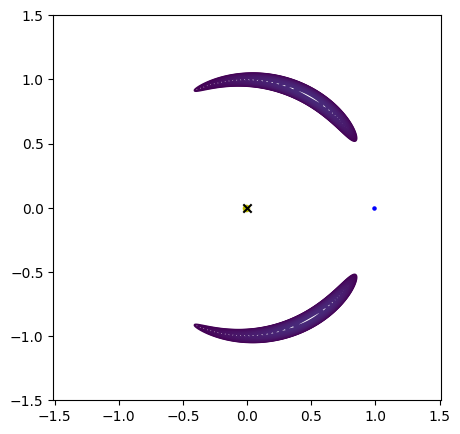

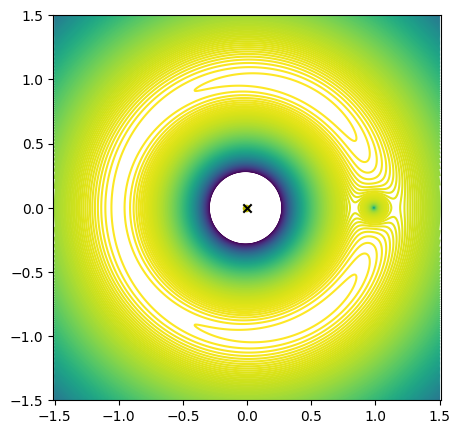

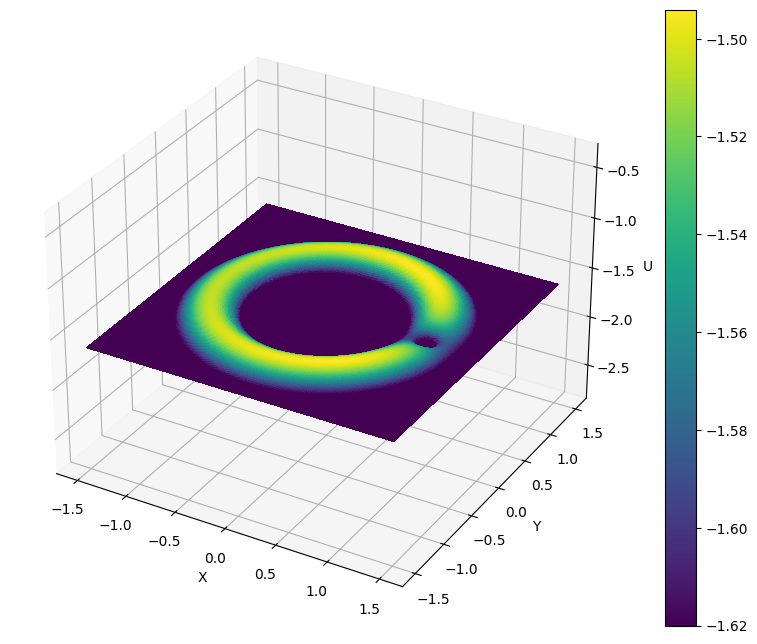

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, fixed

# mu = u
R = 1
sun_pos = np.array([-mu*R, 0])
earth_pos = np.array([(1-mu)*R, 0])

N = 1000
x, y = np.meshgrid(np.linspace(-1.5, 1.5, N), np.linspace(-1.5, 1.5, N))

term1 = -(1-mu) / ((x + mu)**2 + y**2)**0.5
term2 = -mu / ((x - (1-mu))**2 + y**2)**0.5
term3 = -0.5 * (x**2 + y**2)

u = term1 + term2 + term3

plt.figure(figsize=(5, 5))
levels = np.linspace(-1.5, -1.45, 200)
plt.contour(x, y, u, levels=levels)
plt.scatter([sun_pos[0]], [sun_pos[1]], c='y', s=20)
plt.scatter([earth_pos[0]], [earth_pos[1]], c='b', s=5)
plt.scatter([0], [0], c='k', marker='x')
plt.axis('equal')

plt.figure(figsize=(5, 5))
levels = np.linspace(-3.5, -1.5, 200)
plt.contour(x, y, u, levels=levels)
plt.scatter([sun_pos[0]], [sun_pos[1]], c='y', s=20)
plt.scatter([earth_pos[0]], [earth_pos[1]], c='b', s=5)
plt.scatter([0], [0], c='k', marker='x')
plt.axis('equal')


u = np.where(u <= -1.62, -1.62, u)

# Create 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, u, cmap='viridis',  rstride=5, cstride=5, antialiased=False)



# Add labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('U')


# Add colorbar
fig.colorbar(surf)

plt.axis('equal')

# Show the plot
plt.show()

In [66]:
#Define the m1-m2 ratio, mu
mu = M_moon/(M_earth+M_moon)

#Compute the hill radius
rh = ((1/3)*mu)**(1/3)

#Compute the initial guesses for L1 and L2
y1 = rh*(1-(1/3)*rh - (1/9)*rh**2)

y2 = rh*(1+(1/3)*rh - (1/9)*rh**2)

# Coefficients to the quintic function: d/dx(-Ueff) = 0
coefficients1 = [1, 3-mu, 3-2*mu, -mu, -2*mu, -mu]
coefficients2 = [1, -(3-mu), 3-2*mu, -mu, 2*mu, -mu]

# Use newtons method to solve the quintic
L1 = newtons_method(coefficients1, y1)
L2 = newtons_method(coefficients2, y2)

# The resulting solutions are from the m2 reference, convert to m1 reference
L1 = (1 - mu) - y1
L2 = (1 - mu) + y2

print(L1)
print(L2)

0.8373962088414884
1.1552480801630263


## Computing Analytical P.O. First Guesses

In [114]:
xe = L2

#Define an amplitude for the initial conditions
A = .001
#Changing coordinates to (xe,0,0,xe), the mass ratio becomes
u_bar = mu*abs(xe-1+mu)**(-3) + (1-mu)*abs(xe+mu)**(-3)


v = .5*(u_bar-2-sqrt(9*u_bar**2 - 8*u_bar))
print(v)
print(u_bar)
tau = -(v**2 + 2*u_bar + 1)/(2*v)

y_0 = -A*v*tau

x_0 = [xe - A, 0, 0, 0, y_0, 0]

print(x_0)
# a = 2*u_bar+1
# b = u_bar-1

# x_dot = vx
# y_dot = vy
# vx_dot = 2*vy +a*x
# vy_dot = -2*vx-b*y

-3.489618224854354
3.2102003892807236
[1.1542480801630264, 0, 0, 0, 0.00979891806689855, 0]


## Integrating and Correcting the Guesses

In [64]:

t_span = (0, 2551520/10000)
t = np.linspace(t_span[0], t_span[1], num=100000)

x_0_m = np.array([-383781, 0, 0, 0, 1.022, 0])
x_0_s = x_0_m + np.array([-100, 0, 0, 0, .656, 0])
x_0_s = x_0_m + np.array([-100, 0, 0, 0, 5, 0])


x_0 = np.concatenate((x_0_m[:3],x_0_s[:3], x_0_m[3:], x_0_s[3:]))



# y = odeint(lunar_DEQ, x_0,t)
sol = solve_ivp(lunar_Orbit_DEQ, t_span, x_0,t_eval=t, dense_output='True', rtol=1e-11, atol=1e-11 )



## Plotting Periodic Orbits

[1.1552480801630263, 0, 0, 0, 0, 0]


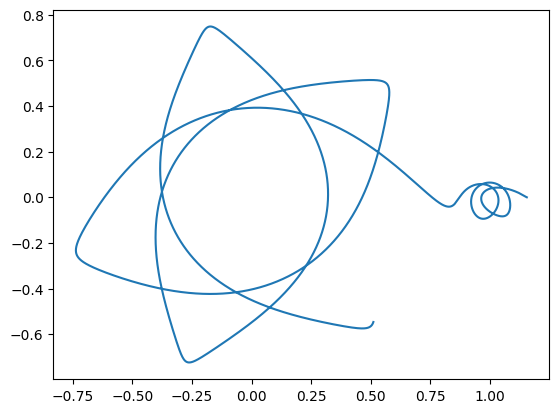

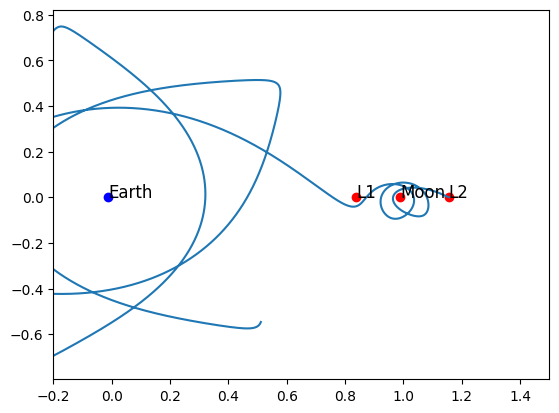

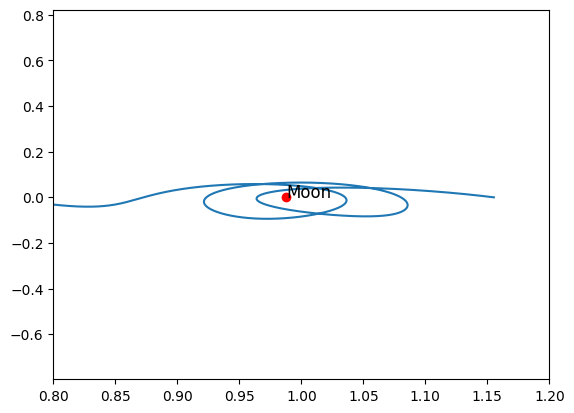

In [115]:
x_0 = [xe, 0, 0, 0, 0, 0]

G = 1

M_earth = 5.972e24
M_moon = 7.342e22

u2 = M_moon/(M_earth+M_moon)
u1 = 1-u2


L_f = 1/(383400)
V_f = 1/(1.071)
t_f = 2*np.pi/(2360320)

t_span = (0, 20)
t = np.linspace(t_span[0], t_span[1], num=10000)

# print(t)
# print(t_span)
# x_0_m = np.array([383781*L_f, 0, 0, 0, 1.022*V_f, 0])
# x_0_s = x_0_m + np.array([100*L_f, 0, 0, 0, .656*V_f, 0])



# x_0 = np.concatenate((x_0_s[:3], x_0_s[3:]))

print(x_0)

# y = odeint(lunar_DEQ, x_0,t)
sol = solve_ivp(lunar_Orbit_DEQ_rotating, t_span, x_0,t_eval=t, dense_output='True', rtol=1e-14, atol=1e-14 )


#Extract Satellite position components
x_s = sol.y[0,:]
y_s = sol.y[1,:]


#Extract Satellite position Vector
r_s = sol.y[0:3,:]


plt.plot(x_s, y_s)
# plt.xlim(-1.2, -.8)
# plt.ylim(-.2, .2)
# plt.axis('equal')


plt.show()

plt.plot(x_s, y_s)
plt.xlim(-.2, 1.5)
# plt.ylim(-.2, .2)
# plt.axis('equal')
x_points = [-u2, u1, L1, L2]
y_points = [0, 0, 0 ,0]

labels = ['Earth', 'Moon', 'L1', 'L2']
plt.scatter(x_points[0], y_points[0], color='Blue')
plt.scatter(x_points[1:], y_points[1:], color='Red')
for label, x_val, y_val in zip(labels, x_points, y_points):
    plt.text(x_val, y_val, label, fontsize=12, ha='left')
plt.show()

plt.plot(x_s, y_s)
plt.xlim(.8, 1.2)
# plt.ylim(-.2, .2)
# plt.axis('equal')
x_points = [-u2, u1]
y_points = [0, 0]


plt.scatter(u1, 0, color='Red')


plt.text(u1, 0, "Moon", fontsize=12, ha='left')
plt.show()
# x_points = [0, 326390, 448900]
# y_points = [0, 0, 0]

# labels = ['Earth', 'L1', 'L2']
# plt.scatter(x_points[0], y_points[0], color='Blue')
# plt.scatter(x_points[1:], y_points[1:], color='Red')
# for label, x_val, y_val in zip(labels, x_points, y_points):
#     plt.text(x_val, y_val, label, fontsize=12, ha='left')

# plt.plot(x_m, y_m)
# plt.plot(x_s, y_s)
# plt.axis('equal')
# plt.show()

In [ ]:
u = M_moon/(M_earth+M_moon)

def Jacobi_Const(u,s):
    #This function computes the jacobi constant for
    #a given body in the rotating fixed frame of the CR3BP 
    #u: the mass ratio of the two primary bodies, M2/(M1+M2)
    #s: the object state, a list or ndarray structured as: [x, y, z, dx, dy, dz]
    #NOTE: s must be given in non-dimensional units for this formula to be valid
    
    #Extract state variables
    x = s[0]
    y = s[1]
    z = s[2]

    dx = s[3]
    dy = s[4]
    dz = s[5]

    #Compute the relative position magnitudes
    r1 = np.sqrt((x+u)**2 + y**2 + z**2)
    r2 = np.sqrt((x-1+u)**2 + y**2 + z**2)
    
    #Compute the jacobi constant
    CJ = (x**2 + y**2) + (2*(1-u)/r1) + (2*u/r2) - dx**2 - dy**2 - dz**2
    
    return CJ

s = sol.y[[3, 4, 5, 9, 10, 11],:]

CJ = Jacobi_Const(u,s)

print(CJ)

In [6]:
sqrt(2)

1.4142135623730951

In [ ]:
# Step 1: Construct initial guess
initial_guess = construct_initial_guess()

# Step 2: Discretize into multiple arcs
arcs = discretize(initial_guess)

# Step 3: Set states at the beginning of all arcs as free variables
free_variables = get_initial_states(arcs)

# Step 4: Iteratively adjust free variables for continuity
while not converged:
    # Compute state trajectory for each arc
    for arc in arcs:
        trajectory = integrate(arc, free_variables)
        
        # Adjust free variables using Newton's method
        free_variables = adjust_variables(arc, free_variables, trajectory)
    
    # Check for convergence
    if within_tolerance(free_variables):
        break

# Step 5: Use pseudo-arclength continuation
while not termination_criteria_met():
    # Compute additional members along the periodic orbit family
    additional_member = pseudo_arclength_continuation(arcs, free_variables)
    
    if termination_criteria_met():
        break

# Final Result: Obtained periodic orbit
final_periodic_orbit = concatenate_arcs(arcs)

In [137]:
#Use Curtis book to formulate motion in earth-moon co-rotating frame

#non-dimensionalize plots/data
#Plot trajectories
#Vary initial conditions, try to match variance wth paper
#Perform stability analysis


## Construct Motion Primitive Library

## Construct Motion Primitive Graph

## Identify Candidate Motion Primitive Sequences

## Construct an Initial Guess from a Primitive Sequence

## Recover a Continuous Trajectory

## Explore the Transfer Design Space